In [1]:
import torch
import pickle
import numpy as np

fn = "datahidden/shpllama1b/SHPLlama-3.2-1B"
with open(fn, 'rb') as f:
    (chosen_features_list, rejected_features_list, chosen_features_list_eval, rejected_features_list_eval) = pickle.load(f)

chosen_features_list = chosen_features_list[:999]
rejected_features_list = rejected_features_list[:999]

In [2]:
print(f'length of chosen_features_list: {len(chosen_features_list)}')
chosen_features = torch.cat(chosen_features_list, dim=0).float()
rejected_features = torch.cat(rejected_features_list, dim=0).float()
print(f'chosen_features.shape: {chosen_features.shape}')
print(f'rejected_features.shape: {rejected_features.shape}')

print(f'length of chosen_features_list_eval: {len(chosen_features_list_eval)}')
chosen_features_eval = torch.cat(chosen_features_list_eval, dim=0).float()
rejected_features_eval = torch.cat(rejected_features_list_eval, dim=0).float()
print(f'chosen_features_eval.shape: {chosen_features_eval.shape}')
print(f'rejected_features_eval.shape: {rejected_features_eval.shape}')

n_samples = chosen_features.shape[0]


length of chosen_features_list: 807
chosen_features.shape: torch.Size([12903, 2048])
rejected_features.shape: torch.Size([12903, 2048])
length of chosen_features_list_eval: 43
chosen_features_eval.shape: torch.Size([682, 2048])
rejected_features_eval.shape: torch.Size([682, 2048])


In [3]:
diff_features = chosen_features - rejected_features
print(f'diff_features.shape: {diff_features.shape}')

diff_features_eval = chosen_features_eval - rejected_features_eval
print(f'diff_features_eval.shape: {diff_features_eval.shape}')


diff_features.shape: torch.Size([12903, 2048])
diff_features_eval.shape: torch.Size([682, 2048])


In [4]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a neural network with no hidden layer
class NeuralNetworkNoHidden(torch.nn.Module):
    def __init__(self, input_size, output_size=1):
        super(NeuralNetworkNoHidden, self).__init__()
        self.outputlayer = torch.nn.Linear(input_size, output_size, bias=False)

    def forward(self, x):
        r = self.outputlayer(x)
        return r



In [5]:
import torch.nn.functional as F
def l1_2_norm(weight_matrix):
    row_l2_norms = torch.norm(weight_matrix, p=2, dim=1)
    l1_2 = torch.sum(row_l2_norms)
    return l1_2

def train_neural_network_no_hidden(model, optimizer, scheduler, diff,  beta, steps=1000, seed=0):
    n, d = diff.shape
    loss_history = []
    torch.manual_seed(seed)
    for step in range(int(steps)):
        optimizer.zero_grad()
        output = model(diff)
        loss = - F.logsigmoid(output).sum() / n
        loss += beta * model.outputlayer.weight.norm(1)
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_history.append(loss.item())
        if step % 200 == 0:
            print(f"Step {step}, Loss: {loss.item()}")
    acc = (model(diff) > 0).float().mean()
    return model, acc, loss_history



In [6]:
import pandas as pd
import matplotlib.pyplot as plt

_, d = diff_features.shape
lr = 1e-3
wd = 1e-2
steps = int(2e3)
rate = 1
lr_nohidden = lr
n_list = [200, 400, 800, 1600, 3200, 6400]
num_repeats = 5 

results = {
    "n": [],
    "seed": [],
    "beta": [],
    "acc_train": [],
    "acc_eval": [],
    "sparsity": [],
    "sparsity_rough": []
}

for n in n_list:
    for seed in range(num_repeats):  
        torch.manual_seed(seed)  
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)

        diff_features_subset = diff_features[torch.randperm(n_samples)[:n], :]
        
        for beta in [0, 0.5 * (1 / np.sqrt(n))]:  
            print(f"Training no hidden layer model with beta={beta}, n={n}, seed={seed}")

            model_no_hidden = NeuralNetworkNoHidden(input_size=d).to(device)
            optimizer = AdamW(model_no_hidden.parameters(), lr=lr_nohidden, weight_decay=wd)
            scheduler = CosineAnnealingLR(optimizer, T_max=steps)

            model_no_hidden, acc_train_no_hidden, loss_history_no_hidden = train_neural_network_no_hidden(
                model_no_hidden, optimizer, scheduler, diff_features_subset, beta=beta, steps=steps, seed=seed
            )
            acc_eval_no_hidden = (model_no_hidden(diff_features_eval) > 0).float().mean()
            sparsity_no_hidden = (model_no_hidden.outputlayer.weight != 0).float().mean()
            sparsity_no_hidden_rough = (model_no_hidden.outputlayer.weight.abs() > 1e-6).float().mean()

            results["n"].append(n)
            results["seed"].append(seed)
            results["beta"].append(beta)
            results["acc_train"].append(acc_train_no_hidden)
            results["acc_eval"].append(acc_eval_no_hidden)
            results["sparsity"].append(sparsity_no_hidden)
            results["sparsity_rough"].append(sparsity_no_hidden_rough)



Training no hidden layer model with beta=0, n=200, seed=0
Step 0, Loss: 0.6999874711036682
Step 200, Loss: 0.12409786134958267
Step 400, Loss: 0.07933369278907776
Step 600, Loss: 0.06745956093072891
Step 800, Loss: 0.06258139759302139
Step 1000, Loss: 0.06013993173837662
Step 1200, Loss: 0.05880219489336014
Step 1400, Loss: 0.05805892497301102
Step 1600, Loss: 0.057677533477544785
Step 1800, Loss: 0.057527922093868256
Training no hidden layer model with beta=0.035355339059327376, n=200, seed=0
Step 0, Loss: 1.685624599456787
Step 200, Loss: 0.6043628454208374
Step 400, Loss: 0.5955451130867004
Step 600, Loss: 0.5918502807617188
Step 800, Loss: 0.5889717936515808
Step 1000, Loss: 0.5870755910873413
Step 1200, Loss: 0.5853759050369263
Step 1400, Loss: 0.583943247795105
Step 1600, Loss: 0.5829010009765625
Step 1800, Loss: 0.582248330116272
Training no hidden layer model with beta=0, n=200, seed=1
Step 0, Loss: 0.704757034778595
Step 200, Loss: 0.13834014534950256
Step 400, Loss: 0.0953930

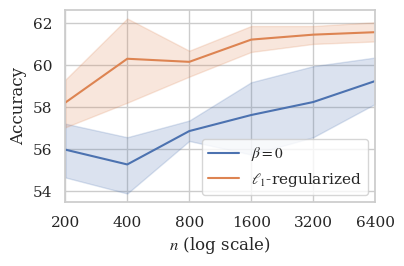

In [7]:

results_cpu = {
    key: [x.cpu().item() if torch.is_tensor(x) else x for x in values]
    for key, values in results.items()
}

df = pd.DataFrame(results_cpu)
df1 = df.copy()
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Serif'
df["beta_category"] = df["beta"].apply(lambda x: "β=0" if x == 0 else "β>0")
df["beta_category"] = df["beta_category"].replace({
    "β=0": r"$\beta = 0$",  
    "β>0": r"$\ell_{1}$-regularized"  
})
df["acc_eval"] = df["acc_eval"].apply(lambda x: x.cpu().item() * 100 if torch.is_tensor(x) else x * 100)

df_summary = df.groupby(["n", "beta_category"]).agg(
    acc_eval_mean=("acc_eval", "mean")
).reset_index()

sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "DejaVu Serif"  
plt.rcParams["mathtext.fontset"] = "stix"  

df = df[df["n"] >= 200]
plt.figure(figsize=(4, 2.5))
sns.lineplot(data=df, x="n", y="acc_eval", hue="beta_category")

plt.xscale("log")
plt.xlabel("$n$ (log scale)")
plt.ylabel("Accuracy")

x_ticks = df["n"].unique()  
plt.xticks(x_ticks, labels=[str(n) for n in x_ticks])  

y_min, y_max = df["acc_eval"].min(), df["acc_eval"].max()
y_ticks = np.linspace(y_min, y_max, num=10)  


plt.xlim(200, 6400) 
plt.legend(title=None)
plt.savefig('last_1B_SHP_0d5.pdf', format='pdf', bbox_inches='tight')

plt.show()
df1.to_json("SHP_results_1B_0d5.json", orient="records", indent=4)
